What you'll learn
An overview of commodity storage contracts
How to extrapolate data from external feeds to provide granular insights
What you'll do
Write code that analyzes data to take a date as input and return a price for past and future estimates
Here is your task
After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data.
Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
Your code should take a date as input and return a price estimate.
Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for. Submit your completed code below.

Note: This role often requires the knowledge and utilization of data analysis and machine learning. Python is a useful tool and one that JPMorgan Chase uses a lot in quantitative research since it’s capable of completing complex tasks.

Moving forward in this program, the example answers are given in Python code. (If Python is not downloaded on your system, you can execute Python code in Jupyter Notebook online for free.)

In [1]:
# Reading the 'Nat_Gas.csv' file using pandas
import pandas as pd
data = pd.read_csv('Nat_Gas.csv')

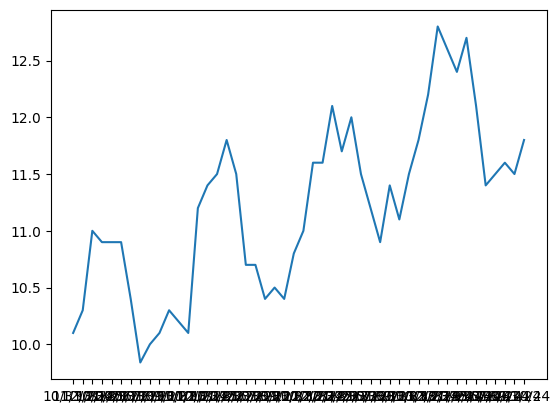

In [2]:
# Plotting the data to get an understanding of the price behavior
import matplotlib.pyplot as plt
plt.plot(data['Dates'], data['Prices'])

In [3]:
# Idea is to use SARIMA (seasonal autoregressive integrated moving average) to model the natural gas prices

data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')
data.set_index('Dates', inplace=True)
data = data.asfreq('M')  # Set the frequency to monthly - tells the model that the data is monthly

C:\Users\darsh\AppData\Local\Temp\ipykernel_18084\133158280.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.asfreq('M')  # Set the frequency to monthly - tells the model that the data is monthly


In [4]:
'''Use SARIMA(p,d,q)(P,D,Q,s), where:
p, d, q = ARIMA terms (trend)
P, D, Q, s = seasonal terms
s = 12 (for yearly seasonality)'''

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model: using (1,1,1)(1,1,1,12) as a starting point
model = SARIMAX(data['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
# forecasting the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int() # confidence intervals - upper and lower bounds of the forecast and is set to 95% by default

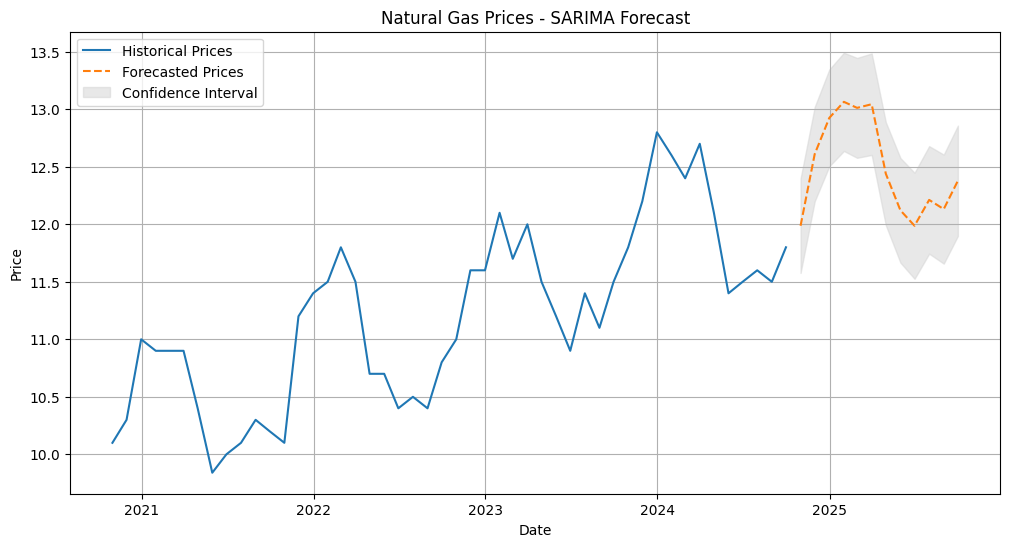

In [6]:
# plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], label='Historical Prices')
plt.plot(predicted_mean.index, predicted_mean, label='Forecasted Prices', linestyle='--')
plt.fill_between(predicted_mean.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title('Natural Gas Prices - SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# function to get the forecasted prices
def estimate_price(date_str):
    target_date = pd.to_datetime(date_str)
    last_date = data.index[-1]
    
    if target_date <= last_date:
        return data.loc[target_date, 'Prices']
    
    # Forecast only if needed
    months_ahead = (target_date.year - last_date.year) * 12 + (target_date.month - last_date.month)
    forecast = results.get_forecast(steps=months_ahead)
    pred_mean = forecast.predicted_mean
    return float(pred_mean[-1].round(2))

In [8]:
estimate_price('12/31/2024')  # Example usage to estimate price for a future date

C:\Users\darsh\AppData\Local\Temp\ipykernel_18084\3352568512.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(pred_mean[-1].round(2))


12.93

In [9]:
# Good start so far. Now I want to create a function that will allow me to estimate the price of natural gas for any date from the current set as well, not just the next 12 months.

def estimate_price(date_str):
    """
    Estimate the gas price for any given date (past or future).
    - Uses actual value if available
    - Interpolates for past dates
    - Forecasts with SARIMA for future dates
    """
    target_date = pd.to_datetime(date_str)
    first_known_date = data.index.min()
    last_known_date = data.index.max()

    # Reindex full known data to daily
    daily_index = pd.date_range(start=first_known_date, end=last_known_date, freq='D')
    daily_prices = data['Prices'].reindex(daily_index)
    interpolated_prices = daily_prices.interpolate('time')

    # 1. If the date is within historical data, return interpolated value
    if target_date <= last_known_date:
        return float(interpolated_prices.loc[target_date].round(2))

    # 2. Else forecast forward using SARIMA
    months_ahead = (target_date.year - last_known_date.year) * 12 + (target_date.month - last_known_date.month)
    forecast = results.get_forecast(steps=months_ahead)
    forecast_mean = forecast.predicted_mean

    # Create monthly forecast index
    forecast_index = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(), periods=months_ahead, freq='M')
    forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

    # Reindex forecast to daily, interpolate, then get the target
    full_forecast_index = pd.date_range(start=forecast_index[0], end=forecast_index[-1], freq='D')
    daily_forecast = forecast_series.reindex(full_forecast_index)
    interpolated_forecast = daily_forecast.interpolate('time')

    return float(interpolated_forecast.loc[target_date].round(2))


In [10]:
estimate_price('12/31/2024')  # Example usage to estimate price for a future date

C:\Users\darsh\AppData\Local\Temp\ipykernel_18084\993426100.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(), periods=months_ahead, freq='M')


12.93

In [11]:
estimate_price('12/31/2023')  # Example usage to estimate price for a date in the past that is in the dataset

12.8

In [12]:
estimate_price('12/29/2023')  # Example usage to estimate price for a date in the past that is not in the dataset

12.76

Now the function can handle both past and future dates, providing interpolated values for past dates and forecasted values for future dates.
The next step is to calculate the error and improve the SARIMA model.

SARIMA(p, d, q)(P, D, Q, s)
p: AR (Auto-Regressive) order — how many past values it uses
d: Differencing order — how many times to difference to make the series stationary
q: MA (Moving Average) order — how many past forecast errors to include
Seasonal part (applies at a periodicity of s, e.g., 12 for monthly seasonality):

P: Seasonal AR order
D: Seasonal differencing order
Q: Seasonal MA order
s: The season length (e.g., 12 for months, 7 for weekly, 365 for daily w/ yearly seasonality)

In [13]:
from pmdarima import auto_arima

model = auto_arima(data['Prices'], 
                   seasonal=True,
                   m=12,              # Set based on your seasonal frequency
                   start_p=0, max_p=3,
                   start_q=0, max_q=3,
                   start_P=0, max_P=2,
                   start_Q=0, max_Q=2,
                   d=None, D=None,    # Let auto_arima decide
                   trace=True,
                   stepwise=True,
                   error_action='ignore',  
                   suppress_warnings=True,
                   n_fits=50)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=50.098, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=37.676, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=41.414, Time=0.10 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=39.189, Time=0.40 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=35.893, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=36.555, Time=0.04 s

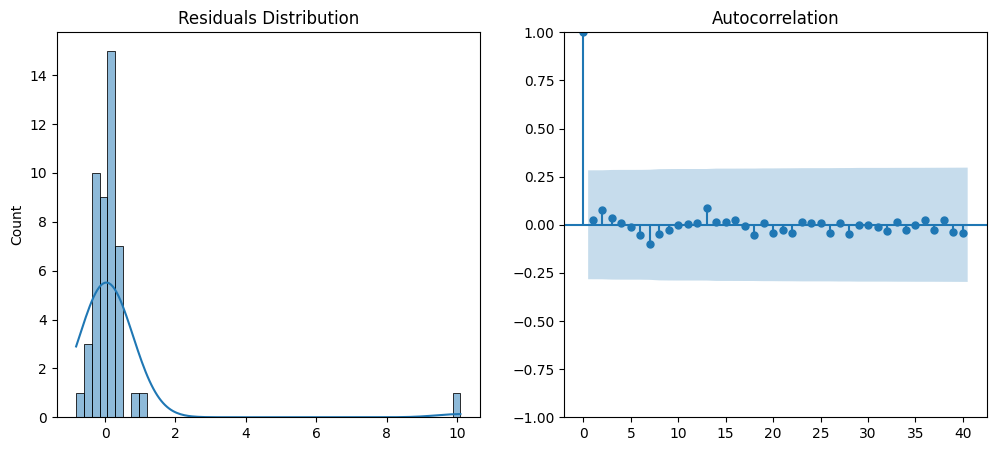

In [15]:
# Now plotting the resuduals
import seaborn as sns
import statsmodels.api as sm

residuals = model.resid()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Residuals Distribution')

sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1])
plt.show()

Left Plot: Residuals Distribution
What it shows:
This histogram (with KDE overlay) visualizes the distribution of residuals, i.e., the difference between our model’s predictions and the actual values.

What we want to see:
Roughly normal distribution (bell-shaped) centered at zero.
No significant skew or extreme outliers.

What the plot shows:
The distribution is right-skewed — long tail to the right.
There’s a visible spike near zero, which is good (means many predictions were close).
But the long tail and a large residual near 10 suggest a few bad prediction errors.

Interpretation:
The model is doing decently overall but:
A few predictions are significantly off, possibly due to sudden jumps or outliers in the data.
Might benefit from outlier detection or transforming the target variable (e.g., log-scaling) if the scale varies wildly.

Right Plot: Autocorrelation of Residuals (ACF)
What it shows:
Autocorrelation plot of the residuals at different lags. Each dot shows how correlated the residuals are with their values from k steps before.

What we want to see:
All points should lie inside the blue confidence band (usually 95%), except maybe at lag 0.
This would mean no significant autocorrelation, i.e., residuals are essentially random noise — which is what we want.

What your plot shows:
All lags except lag 0 (which will always be 1) are within the blue region.
So: residuals are not autocorrelated which is a good sign.